In [1]:
import concurrent.futures
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# metrics
from sklearn.metrics import *

# visuals.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ARK's daily trades
TRADES_DATE = "2021-02-10"
DELTA = 1

year, month, day = TRADES_DATE.split("-")
files = list(Path(f"./trades/").glob(f"ARK_Trade_{''.join([month, day, year])}_*.csv"))
if len(files)>1:
    raise ValueError("more than 1 file for the given date")
    
trades = pd.read_csv(
    files[0],
    header=3,
    usecols=["FUND", "Date", "Direction", "Ticker", "CUSIP", "Name", "Shares", "% of ETF"]
)
trades.columns = trades.columns.map(lambda x:x.lower())
trades.sort_values("ticker", inplace=True)
print(trades.shape)
trades.head()

(21, 8)


,fund,date,direction,ticker,cusip,name,shares,% of etf
0,ARKF,2021-02-10,Buy,1833,G71139102,PING AN HEALTHCARE AND TECHNOLOGY CO LTD,497800,0.1854
4,ARKF,2021-02-10,Sell,3690,G59669104,MEITUAN,200604,0.2930
3,ARKF,2021-02-10,Sell,ADYEN,N3501V104,ADYEN NV,4542,0.3062
20,ARKW,2021-02-10,Sell,API,00851L103,AGORA INC,17639,0.0204
7,ARKG,2021-02-10,Sell,CDNA,14167L103,CAREDX INC,76084,0.0564


In [3]:
# open prices of traded stocks
open_configs = [{"ticker":ticker, "date":TRADES_DATE, "on":"Open"} for ticker in trades["ticker"].unique()] # on ark's trade date

def parallel_fetch_daily_data(config):
    try:
        # fetch daily market data from yahoo finance
        df = web.get_data_yahoo(config["ticker"], start=config["date"], end=config["date"])[[config["on"]]]
        df["ticker"] = config["ticker"]
        df.drop_duplicates(inplace=True)
        return df
    except Exception as e:
        print(e)


open_prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    open_prices.extend(executor.map(parallel_fetch_daily_data, open_configs))
open_prices = pd.concat(open_prices)
open_prices.reset_index(inplace=True)
open_prices.set_index("ticker", inplace=True)
print(open_prices.shape)
open_prices.head()

No data fetched for symbol ADYEN using YahooDailyReader
No data fetched for symbol 3690 using YahooDailyReader
No data fetched for symbol 1833 using YahooDailyReader
(17, 2)


,Date,Open
ticker,,
API,2021-02-10,100.000000
CDNA,2021-02-10,90.508003
EXPC,2021-02-10,17.320000
FATE,2021-02-10,106.169998
KMTUY,2021-02-10,29.920000


In [4]:
# net & volume of trades (assume on open price)
net = trades.copy()[["ticker", "shares", "direction"]]
net["shares"] = net.apply(lambda row:row["shares"] if row["direction"]=="Buy" else -row["shares"], axis=1)
net = net.groupby("ticker").sum()

net = net.join(open_prices, how="inner") # link to price

net["signal"] = net["shares"].apply(lambda x: "Buy" if x>0 else "Sell")
net["volume"] = net["shares"] * net["Open"]
net["abs_volume"] = abs(net["volume"])

net.sort_values("abs_volume", ascending=False, inplace=True)
print(net.shape)
net.style.bar(subset=["abs_volume"], color='lightgreen')

(17, 6)


,shares,Date,Open,signal,volume,abs_volume
ticker,,,,,,
REGN,71033,2021-02-10 00:00:00,493.429993,Buy,35049812.669739,35049812.669739
RHHBY,485288,2021-02-10 00:00:00,43.830002,Buy,21270173.928589,21270173.928589
SPLK,-114882,2021-02-10 00:00:00,172.809998,Sell,-19852758.139526,19852758.139526
NVS,178586,2021-02-10 00:00:00,92.000000,Buy,16429912.000000,16429912.000000
SHOP,10437,2021-02-10 00:00:00,1448.010010,Buy,15112880.471924,15112880.471924
PCAR,71400,2021-02-10 00:00:00,100.309998,Buy,7162133.825684,7162133.825684
CDNA,-76084,2021-02-10 00:00:00,90.508003,Sell,-6886210.918121,6886210.918121
KMTUY,71564,2021-02-10 00:00:00,29.920000,Buy,2141194.885460,2141194.885460
API,-17639,2021-02-10 00:00:00,100.000000,Sell,-1763900.000000,1763900.000000


In [5]:
FUTURE_DATE = datetime.strptime(TRADES_DATE, '%Y-%m-%d') + timedelta(days=DELTA)

# on ark's trades date
configs = [{"ticker":ticker, "date":TRADES_DATE, "on":"Adj Close"} for ticker in trades["ticker"].unique()]
# future date
configs.extend([{"ticker":ticker, "date":FUTURE_DATE, "on":"Adj Close"} for ticker in trades["ticker"].unique()])

prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    prices.extend(executor.map(parallel_fetch_daily_data, configs))
prices = pd.concat(prices)
print(prices.shape)
prices.tail(3)

No data fetched for symbol 1833 using YahooDailyReader
No data fetched for symbol 3690 using YahooDailyReader
No data fetched for symbol ADYEN using YahooDailyReader
No data fetched for symbol 1833 using YahooDailyReader
No data fetched for symbol 3690 using YahooDailyReader
No data fetched for symbol ADYEN using YahooDailyReader
(34, 2)


,Adj Close,ticker
Date,,
2021-02-11,1463.310059,SHOP
2021-02-11,169.960007,SPLK
2021-02-11,50.700001,SSYS


In [6]:
returns = [] # actual price changes
gg = prices.groupby("ticker")
for g in gg.groups:
    gdf = gg.get_group(g)
    if len(gdf)>2:
        raise ValueError("records exceed 2. can only compare 2 records")
    ticker_return = gdf["Adj Close"].pct_change().loc[FUTURE_DATE]
    returns.append({
        "ticker":g,
        "return":ticker_return,
        "actual":"Buy" if ticker_return > 0 else "Sell"
    })
returns = pd.DataFrame(returns)
returns.set_index("ticker", inplace=True)
returns.head(3)

,return,actual
ticker,,
API,0.046967,Buy
CDNA,-0.007077,Sell
EXPC,0.033848,Buy


In [7]:
df = net.join(returns).sort_values("abs_volume", ascending=False)
df.style.apply(
    lambda row:
    [
        'background-color: #f2344c' if row["actual"]!=row["signal"] else 'background-color: #4c864d'
        for i in range(len(df.columns))
    ]
    , axis=1,
)

,shares,Date,Open,signal,volume,abs_volume,return,actual
ticker,,,,,,,,
REGN,71033,2021-02-10 00:00:00,493.429993,Buy,35049812.669739,35049812.669739,-0.001384,Sell
RHHBY,485288,2021-02-10 00:00:00,43.830002,Buy,21270173.928589,21270173.928589,0.001145,Buy
SPLK,-114882,2021-02-10 00:00:00,172.809998,Sell,-19852758.139526,19852758.139526,0.011546,Buy
NVS,178586,2021-02-10 00:00:00,92.000000,Buy,16429912.000000,16429912.000000,0.007871,Buy
SHOP,10437,2021-02-10 00:00:00,1448.010010,Buy,15112880.471924,15112880.471924,0.000609,Buy
PCAR,71400,2021-02-10 00:00:00,100.309998,Buy,7162133.825684,7162133.825684,-0.010040,Sell
CDNA,-76084,2021-02-10 00:00:00,90.508003,Sell,-6886210.918121,6886210.918121,-0.007077,Sell
KMTUY,71564,2021-02-10 00:00:00,29.920000,Buy,2141194.885460,2141194.885460,-0.004017,Sell
API,-17639,2021-02-10 00:00:00,100.000000,Sell,-1763900.000000,1763900.000000,0.046967,Buy


              precision    recall  f1-score   support

         Buy       0.60      0.50      0.55        12
        Sell       0.14      0.20      0.17         5

    accuracy                           0.41        17
   macro avg       0.37      0.35      0.36        17
weighted avg       0.47      0.41      0.43        17



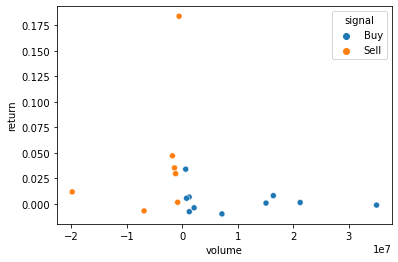

In [8]:
print(classification_report(df["actual"], df["signal"]))
sns.scatterplot(x=df["volume"], y=df["return"], hue=df["signal"])

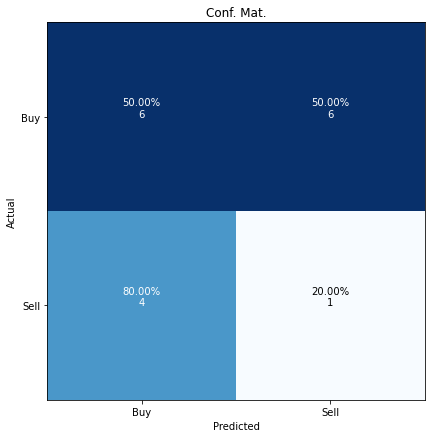

In [9]:
def plot_confusion_matrix_(cm, target_names, title='Conf. Mat.', normalize=True, saveit=False, showit=True):
    import itertools
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     thresh = cm_norm.max() / 1.5 if normalize else cm.max() / 2
    thresh =  cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, 
                     "{:0.2f}%\n{:,}".format(100*cm_norm[i, j], cm[i, j]),
                     horizontalalignment="center",
                     # color="white" if cm_norm[i, j] > thresh else "black",
                     color="white" if cm[i, j] > thresh else "black",
                    )
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    if saveit:
        plt.savefig(fname=saveit)
    if showit:
        plt.show()
plot_confusion_matrix_(confusion_matrix(df["actual"], df["signal"]), ["Buy", "Sell"])